# Setup environment

## Local install
To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within the script itself using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OpenFUSIONToolkit` on macOS).

## Google collab
On Google collab we must download the OFT binary build for Linux from the OFT GitHub page, unpack it in the run directory and add its python directory using `sys.path.append()`. We also install the [wurlitzer](https://pypi.org/project/wurlitzer/) python package to enable printing of system level I/O from the underlying OFT library.

In [1]:
import os
import sys
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    tokamaker_python_path = os.getenv('OFT_ROOTPATH')
    if tokamaker_python_path is not None:
        sys.path.append(os.path.join(tokamaker_python_path,'python'))
    %matplotlib inline
    pass
else:
    !pip install triangle wurlitzer ipympl
    OFT_package = 'OpenFUSIONToolkit_v1.0.0-beta4-Linux-GNU-x86_64'
    OFT_tarball = 'OpenFUSIONToolkit_v1.0.0-beta4-Ubuntu_20_04-GNU-x86_64.tar.gz'
    if not os.path.exists(os.path.join('/content',OFT_package,'python')):
        !wget https://github.com/hansec/OpenFUSIONToolkit/releases/download/v1.0.0-beta4/{OFT_tarball}
        !tar xzf {OFT_tarball}
    OFT_rootpath = os.path.join('/content',OFT_package)
    sys.path.append(os.path.join(OFT_rootpath,'python'))
    %load_ext wurlitzer
    %matplotlib ipympl

## Load other Python packages
We also import [numpy](https://numpy.org/) and [matplotlib](https://matplotlib.org/) for various uses in the script. Default plotting values are also set here to make things more legible on most platforms. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

# A primer on tokamak equilibrium

## Plasma shaping

<p>In tokamaks the shape of the plasma has a strong impact on the performance, stability, and other aspects important for a reactor. As a result, the shape of the plasma is one of the primary considerations in the design of tokamak-based reactors.</p>

<div style="text-align:center" >
<img src="images/ITER_shape.png" width="40%;" style="display:block;margin-left:auto;margin-right:auto;" />
<em style="text-align:center;display:block;margin-left:auto;margin-right:auto;margin-top:0.5em;">Example equilibrium in ITER showing the shape of the plasma (color contours).</em>
</div>

<hr width="0" size="1 em" style="border-width:0" />

<p>In tokamaks the shape of the plasma has a strong impact on the performance, stability, and other aspects important for a reactor. As a result, the shape of the plasma is one of the primary considerations in the design of tokamak-based reactors. The shape of the plasma is principally defined based on the currents in the poloidal field coils (whose current flows toroidally), which push and pull against the plasma current (which also flows toroidally) through the Lorentz force.</p>

<p>A given equilibrium is usually labelled by the shape of its boundary, also called the Last Closed Flux Surface (LCFS), which is described using a Fourier-like representation. These quantities correspond in order of decreasing spatial scale as elongation &kappa; (m=2), triangularity &delta; (m=3), and squareness &zeta; (m=4). The displacement of internal surfaces relative to the boundary surface (m=1) is called the Shafranov shift and is related to how much thermal energy is confined relative to the magnetic field (&beta;).</p>

<hr width="0" size="1 em" style="border-width:0" />

<div style="text-align:center">
<img src="images/shape_params.png" width="40%;" style="display:block;margin-left:auto;margin-right:auto;"/>
<em style="text-align:center;display:block;margin-left:auto;margin-right:auto;margin-top:0.5em;">Heirarchy of shaping parameters for tokamak equilibria</em>
</div>

<h2>Internal profiles</h2>

<p>In addition to the shape of the plasma boundary we also need to design the internal characteristics of the plasma by setting profiles for the $P'$ and $F*F'$ source terms on the right hand side of the Grad-Shafranov equation. Remember that these source terms relate to the confining and force-free currents that flow in the plasma. The total plasma pressure, which sets $P'$, is a combination of the pressures of the various species, which consist of electrons and multiple ion species (eg. D, T, He), which depends on their densities and temperatures. Additionally, in a tokamak the plasma current, from both $P'$ and $F*F', must be sustained using external means or self-generated via the so-called "bootstrap" effect.</p>

<hr width="0" size="1 em" style="border-width:0" />

<div style="text-align:center">
<img src="images/SPARC_profiles.png" width="60%;" style="display:block;margin-left:auto;margin-right:auto;"/>
<em style="text-align:center;display:block;margin-left:auto;margin-right:auto;margin-top:0.5em;">Example of plasma shape (left) and kinetic (center) and current (right) profile predictions from design of the SPARC tokamak [<a href="https://doi.org/10.1017/S0022377820001075">Rodriguez-Fernandez et al., J. Plasma Phys. (2020)</a>].</em>
</div>

<h2>Putting it together</h2>

<p>When designing a new tokamak engineers can use an equilibrium tool, like TokaMaker, to compute candidate equilibrium with different shapes and internal profiles to find the configuration that best balances performance, operational, and other objectives. Quantities like fusion power, required heating & current drive power, required shielding, breeding ratio, magnet location, etc. are all dependent on the characteristics of this core plasma.</p>

<hr width="0" size="1 em" style="border-width:0" />

<div style="text-align:center">
<img src="images/POPCON_ex.png" width="40%;" style="display:block;margin-left:auto;margin-right:auto;"/>
<em style="text-align:center;display:block;margin-left:auto;margin-right:auto;margin-top:0.5em;">Example of high-level design optimization for the SPARC tokamak using a fixed plasma shape [<a href="https://doi.org/10.1017/S0022377820001257">Creely et al., J. Plasma Phys. (2020)</a>].</em>
</div>

# Computing equilbria with a known boundary

## Load TokaMaker objects from OFT
Here we load the components we need from the [OpenFUSIONToolkit](https://github.com/hansec/OpenFUSIONToolkit) python interface. In this example we will use:
 * [TokaMaker](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html): The main driver class for computing equilibrium
 * [gs_Domain](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1meshing_1_1gs__Domain.html): A class for defining geometry for the plasma and other device components
 * [create_isoflux](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1util.html#ac5dd5032d63d24acc29c6e1cc39a7505): A helper function that builds surfaces using a standard tokamak definition based on (&kappa; and &delta;)
 * [create_power_flux_fun](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1util.html): A helper function that builds definitions for $P'$ and $F*F'$ with a simple power-like form

In [3]:
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_power_flux_fun

### Define boundary
First let's define the boundary of the equilibrium we want to compute. We'll do this using the [create_isoflux](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1util.html#ac5dd5032d63d24acc29c6e1cc39a7505) method, which returns a curve parameterized using a center point (R,Z), minor radius (a), and elongation (&kappa;) and triangularity (&delta;). For this case we will define a circular plasma ($\kappa=1, \delta=0$) with ITER-like size of 6.3 m major radius and 2 m minor radius.

In [4]:
n_boundary = 40
R0 = 6.3
Z0 = 0.0
r_minor = 2.0
kappa = 1.0
delta = 0.0
LCFS_contour = create_isoflux(n_boundary,R0,Z0,r_minor,kappa,delta)

### Generate TokaMaker mesh
TokaMaker solves for equilibria by representing the solution using a finite element representation on a triangular mesh. Here we build a suitable mesh using the [gs_Domain](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1meshing_1_1gs__Domain.html) class. To build a mesh we first define the logical regions using `define_region()` and then add the geometry itself using `add_polygon()`, where other shape types are also available.

In this example we have on a single `plasma` region, with a grid resolution of 1/15 the minor radius. The boundary of this region is the LCFS contour computed above.

Once the geometry is defined we can generate the actual mesh using `build_mesh()`. This step may take a few moments as the [triangle](https://www.cs.cmu.edu/~quake/triangle.html) library generates the triangular mesh. The resulting mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,).

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('plasma',r_minor/15.0,'plasma')
# Define shape of the plasma
gs_mesh.add_polygon(LCFS_contour,'plasma')
# Generate mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()

Assembling regions:
  # of unique points    = 94
  # of unique segments  = 1
Generating mesh:
  # of points  = 1121
  # of cells   = 2146
  # of regions = 1


### Plot resulting regions and grid
We can use `plot_mesh()` to view the mesh and inspect it for any errors.

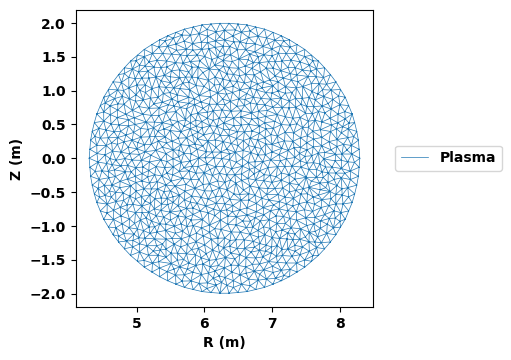

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

## Compute equilibria

### Initialize TokaMaker object
Now that we have a mesh we can create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [7]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   gh-pages
Revision id:          91df4c8
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated above using [setup_mesh](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#aeebfee91bbc5bb6541004aa4086fc6fe) and set the code to operate in fixed boundary mode by setting the `free_boundary` setting to False. Finally, we call [setup](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#add88b096976310b2af286559c504ebfe) to setup the required solver objects. During this call we also specify the vacuum toroidal field through $F_0 = B_0*R_0$, where $B_0$ is the toroidal field at a reference location $R_0$. Here we use ITER-like values of 5.3 T @ 6.2 m.

**Note:** If you would like to change the mesh without restarting the notebook use [reset](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a51829b63adb24ac48d350dee60181002) to clear the current mesh and call `setup_mesh()` and `setup()` again with the new mesh.

In [8]:
mygs.setup_mesh(mesh_pts,mesh_lc)
mygs.settings.free_boundary = False
mygs.setup(F0=5.3*6.2)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.251E+01
    # of points  =    1121
    # of edges   =    3266
    # of cells   =    2146
    # of boundary points =      94
    # of boundary edges  =      94
    # of boundary cells  =      94
  Resolution statistics:
    hmin =  8.292E-02
    hrms =  1.218E-01
    hmax =  1.989E-01
  Surface grounded at vertex      48


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1



### Define flux functions
Here we define flux functions for $P'$ and $F*F'$ for use in the G-S solve. In this case we will use L-mode-like profiles of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, where $\alpha$ and $\gamma$ are set differently for $P'$ and $F*F'$ to provide broad ($\alpha=1.5, \gamma=2.0$) and peaked ($\alpha=4.0, \gamma=1.0$) profiles respectively.

After building the profiles they can be plotted using the `'x'` and `'y'` dictionary fields.

Finally, the profiles are set in TokaMaker using the `set_profiles()` method.

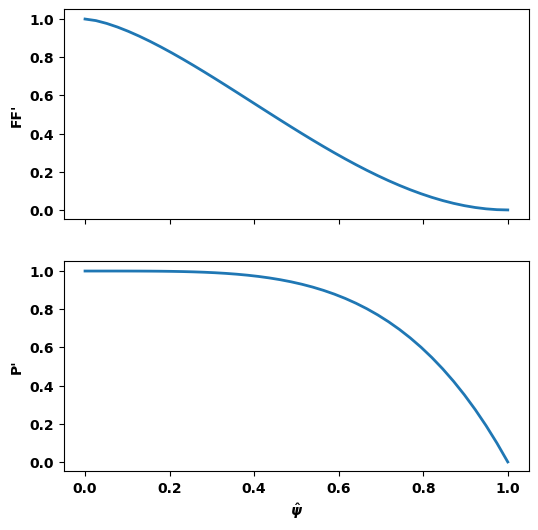

In [9]:
# Build profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

# Plot profiles
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

# Set profiles in TokaMaker
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Define global quantities and targets
For the Grad-Shafranov solve we also define targets for the plasma current ($I_P$) and the ratio of the contributions of $P'$ and $F*F'$ to the total plasma current (`Ip_ratio`), which is related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$. This is done through a call to [set_targets](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ac9798f691c087d62259ceda8ebe6b0ab). During solution the scale of the $P'$ and $F*F'$ profiles will be adjusted to match these targets.

In [10]:
Ip_target=2.0E6
ratio_target=5.0
mygs.set_targets(Ip=Ip_target, Ip_ratio=ratio_target)

### Initialize $\psi$
Before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using [init_psi](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ae532f03c0978180dbd5677e1432a9f7f). By default, this calculation uses a uniform current (equal to Ip_target) over the full plasma domain. Additional options are also availble to tailor this distribution for more control.

While all the fields are set at this point the solution is not a true equilibrium.

In [11]:
err_flag = mygs.init_psi()

### Compute Grad-Shafranov equilibrium
Now we can compute the full equilibrium using [solve](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#acae14bbdb859253db974e30b7c92be02).

The output should show convergence of the residual (fourth column) as the nonlinear Grad-Shafranov equation is solved.

In [12]:
err_flag = mygs.solve()

Starting non-linear GS solver
     1  4.7797E+00  6.6496E-03  8.5299E-03  6.4820E+00  1.8083E-05  0.0000E+00
     2  5.4851E+00  7.0769E-03  3.2333E-03  6.4711E+00  2.3127E-05  0.0000E+00
     3  5.7638E+00  7.2383E-03  1.3063E-03  6.4680E+00  2.3186E-05  0.0000E+00
     4  5.8799E+00  7.3016E-03  5.4478E-04  6.4672E+00  2.1399E-05  0.0000E+00
     5  5.9290E+00  7.3271E-03  2.3080E-04  6.4671E+00  2.0784E-05  0.0000E+00
     6  5.9499E+00  7.3375E-03  9.9058E-05  6.4672E+00  2.0657E-05  0.0000E+00
     7  5.9589E+00  7.3417E-03  4.3250E-05  6.4673E+00  2.0771E-05  0.0000E+00
     8  5.9628E+00  7.3435E-03  1.9370E-05  6.4674E+00  2.0931E-05  0.0000E+00
     9  5.9644E+00  7.3443E-03  8.9832E-06  6.4674E+00  2.1058E-05  0.0000E+00
    10  5.9652E+00  7.3446E-03  4.3466E-06  6.4675E+00  2.1147E-05  0.0000E+00
    11  5.9655E+00  7.3447E-03  2.1978E-06  6.4675E+00  2.1204E-05  0.0000E+00
    12  5.9657E+00  7.3448E-03  1.1556E-06  6.4675E+00  2.1240E-05  0.0000E+00
    13  5.9657E+00  7.

### Print information and plot equilibrium
After computing the equilibrium, basic parameters can be displayed using the [print_info](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a46c8bde43e120175614bb373c18a970c) method. For access to these quantities as variables instead the [get_stats](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a30af13a91045f3a12a6a1f59239cce2b) can be used.

In [13]:
mygs.print_info()

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    2.0000E+06
  Current Centroid [m]    =    6.350  0.000
  Magnetic Axis [m]       =    6.468  0.000
  Elongation              =    0.999 (U:  0.999, L:  0.999)
  Triangularity           =    0.002 (U: -0.025, L:  0.028)
  Plasma Volume [m^3]     =   495.018
  q_0, q_95               =    3.110  8.454
  Peak Pressure [Pa]      =    1.0250E+04
  Stored Energy [J]       =    2.5504E+06
  <Beta_pol> [%]          =   21.0712
  <Beta_tor> [%]          =    0.0322
  Diamagnetic flux [Wb]   =    3.7512E-02
  Toroidal flux [Wb]      =    6.6988E+01
  l_i                     =    1.1129


Flux surfaces can be plotted using the [plot_psi](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a61550b8069c6e27d978fac742b620089) method.

Text(0.5, 0, 'R [m]')

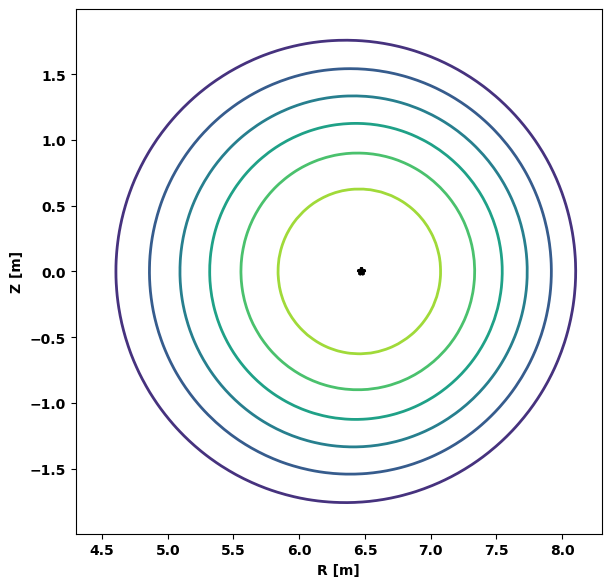

In [14]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
mygs.plot_psi(fig,ax)
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')

# Scanning peak pressure

Before performing a scan we can turn off the progress printing from above by adjusting the `pm` setting to False and calling `update_settings()`.

In [15]:
mygs.settings.pm=False
mygs.update_settings()

Now we will perform a scan of plasma pressure by adjusting the `Ip_ratio` target. At each value we re-solve the G-S equation and plot the evolution of the magnetic axis location (stored in `o_point`), $\beta_p$ (from `get_stats()`) and q-profile (from `get_q()`).

As the peak pressure increases so does the plasma $\beta$ and the shift of the magnetic axis from the geometric center of the LCFS. Additionally, the q-profile flattens as the plasma pressure increases, which is a consequence of the relative shape of the $P'$ and $F*F'$ profiles chosen above.

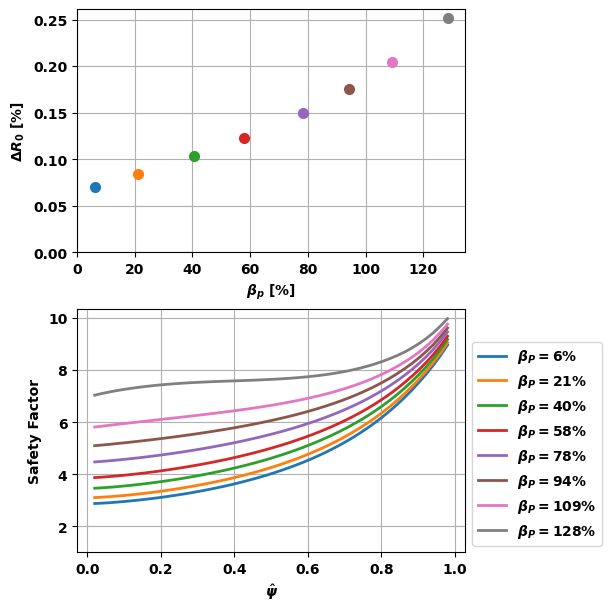

In [16]:
# Create figure
fig, (r_ax, q_ax) = plt.subplots(2,1,constrained_layout=True)

# Loop over a range of pressures
for ratio_target_tmp in (20.0, 5.0,2.0,1.0,0.4,0.1,-0.1,-0.3):
    
    # Update targets and re-solve
    mygs.set_targets(Ip=Ip_target, Ip_ratio=ratio_target_tmp)
    err_flag = mygs.solve()
    stats_dict = mygs.get_stats()

    # Plot shift in magnetic axis
    r_ax.plot(stats_dict['beta_pol'],(mygs.o_point[0]-R0)/r_minor,'o')
    
    # Plot evolution of q-profile
    psi_q,qvals,_,_,_,_ = mygs.get_q()
    q_ax.plot(psi_q,qvals,label=r'$\beta_P = {0:.0f}\%$'.format(stats_dict['beta_pol']))

# Format plots
q_ax.grid(True)
q_ax.legend(loc='lower left',bbox_to_anchor=(1.0, 0.0))
q_ax.set_ylim(bottom=1.0)
q_ax.set_ylabel(r'Safety Factor')
q_ax.set_xlabel(r'$\hat{\psi}$')
r_ax.grid(True)
r_ax.set_ylim(bottom=0.0)
r_ax.set_xlim(left=0.0)
r_ax.set_ylabel(r'$\Delta R_0$ [%]')
_ = r_ax.set_xlabel(r'$\beta_p$ [%]')

# Choose your own adventure

 * What does the $\beta_p$ vs `Ip_ratio` look like?
 * What does $\Delta R_0$ vs $\beta_p$ look like?
 * What is the maximum plasma current you can get with $q_{max} > 1$?
 * How does this change with the shape of the profiles?